In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


In [2]:
from tensorflow import keras  #这里的波浪线不用管

#用karas有的数据集imdb，电影分类,分电影是积极的，还是消极的
imdb = keras.datasets.imdb
#载入数据使用下面两个参数
vocab_size = 10000  #词典大小，仅保留训练数据中前10000个最经常出现的单词，低频单词被舍弃
index_from = 3  #0,1,2,3空出来做别的事
#前一万个词出现词频最高的会保留下来进行处理，后面的作为特殊字符处理，
# 小于3的id都是特殊字符，下面代码有写
# 需要注意的一点是取出来的词表还是从1开始的，需要做处理
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from=index_from)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 150s 9us/step


In [3]:
type(train_labels)#查看数据类型

numpy.ndarray

In [4]:
print(type(train_data))#查看数据类型

<class 'numpy.ndarray'>


In [5]:
train_data.shape  #每个样本是一段话，每个单词用一个数字表示

(25000,)

In [6]:
type(train_data[0])  #查看数据类型

list

In [7]:
train_data[2]  #查看数据

[1,
 14,
 47,
 8,
 30,
 31,
 7,
 4,
 249,
 108,
 7,
 4,
 5974,
 54,
 61,
 369,
 13,
 71,
 149,
 14,
 22,
 112,
 4,
 2401,
 311,
 12,
 16,
 3711,
 33,
 75,
 43,
 1829,
 296,
 4,
 86,
 320,
 35,
 534,
 19,
 263,
 4821,
 1301,
 4,
 1873,
 33,
 89,
 78,
 12,
 66,
 16,
 4,
 360,
 7,
 4,
 58,
 316,
 334,
 11,
 4,
 1716,
 43,
 645,
 662,
 8,
 257,
 85,
 1200,
 42,
 1228,
 2578,
 83,
 68,
 3912,
 15,
 36,
 165,
 1539,
 278,
 36,
 69,
 2,
 780,
 8,
 106,
 14,
 6905,
 1338,
 18,
 6,
 22,
 12,
 215,
 28,
 610,
 40,
 6,
 87,
 326,
 23,
 2300,
 21,
 23,
 22,
 12,
 272,
 40,
 57,
 31,
 11,
 4,
 22,
 47,
 6,
 2307,
 51,
 9,
 170,
 23,
 595,
 116,
 595,
 1352,
 13,
 191,
 79,
 638,
 89,
 2,
 14,
 9,
 8,
 106,
 607,
 624,
 35,
 534,
 6,
 227,
 7,
 129,
 113]

In [8]:
len(train_data[0])  #查看数据长度

218

In [9]:
len(train_data[1])  #查看数据长度

189

In [10]:
print("train", len(train_data), train_labels.shape)  #25000个样本，每个样本是一段话，每个单词用一个数字表示
print("test", len(test_data), test_labels.shape)

train 25000 (25000,)
test 25000 (25000,)


In [11]:
#载入词表，看下词表长度，词表就像英语字典
word_index = imdb.get_word_index()
print(len(word_index))
print(type(word_index))
#词表虽然有8万多，但是我们只载入了最高频的1万词！！！！

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 48s 29us/step
88584
<class 'dict'>


In [12]:
word2idx = {word: idx + 3 for word, idx in word_index.items()}  # 0,1,2,3空出来做别的事,这里的idx是从1开始的,所以加3
word2idx.update({
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
})

idx2word = {idx: word for word, idx in word2idx.items()}  # 反向词典,id变为单词

In [13]:
print(word2idx["world"])  # 10000

182


In [14]:
idx2word[4]

'the'

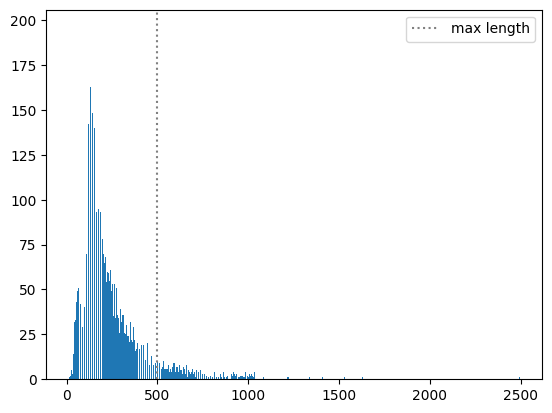

In [15]:
# 选择 max_length
length_collect = {}
#统计样本中每个长度出现的次数
for text in train_data:
    length = len(text)  #句子长度
    length_collect[length] = length_collect.get(length, 0) + 1  #统计长度的频率

MAX_LENGTH = 500
plt.bar(length_collect.keys(), length_collect.values())  #长度分布图
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")  #画一条线，可以看到大部分都在500以内
plt.legend()#显示图例
plt.show()#显示图形

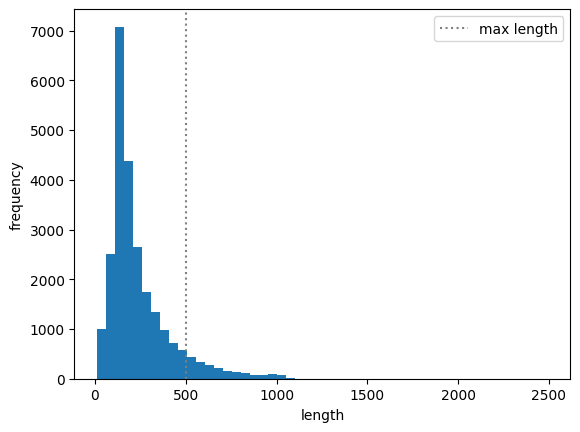

In [16]:
#想对句子长度画个直方图，看看长度分布
length_list = [len(text) for text in train_data]
plt.hist(length_list, bins=50)
plt.xlabel("length")
plt.ylabel("frequency")
plt.axvline(500, label="max length", c="gray", ls=":")
plt.legend()
plt.show()

In [17]:
length_list[0:10]#查看前10个句子的长度

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]

In [18]:
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]#测试用例
raw_text#查看测试用例

[['hello', 'world'],
 ['tokenize', 'text', 'datas', 'with', 'batch'],
 ['this', 'is', 'a', 'test']]

In [19]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx  #词表,单词到id
        self.idx2word = idx2word  #词表，id到单词
        self.max_length = max_length
        self.pad_idx = pad_idx  #填充
        self.bos_idx = bos_idx  #开始
        self.eos_idx = eos_idx  #结束
        self.unk_idx = unk_idx  #未知，未出现在最高频词表中的词

    def encode(self, text_list):
        """
        将文本列表转化为索引列表
        :param text_list:当前批次的文本列表
        :return:
        """
        max_length = min(self.max_length, 2 + max(
            [len(text) for text in text_list]))  #最大长度，最大长度是500，但是如果句子长度小于500，就取句子长度（句子长度是本组句子中最长的），2是为了留出开始和结束的位置
        indices = []
        for text in text_list:
            index = [self.word2idx.get(word, self.unk_idx) for word in text]  #单词转化为id，未知的词用unk_idx代替
            index = [self.bos_idx] + index + [self.eos_idx]  #添加开始和结束
            if len(index) < max_length:
                index = index + [self.pad_idx] * (max_length - len(index))  #填充0
            else:
                index = index[:max_length]  #如果句子长度大于500，就截断
            indices.append(index)
        return torch.tensor(indices)  #二维列表转化为tensor

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        将索引列表转化为文本列表
        :param indices_list:某批次的索引列表
        :param remove_bos:
        :param remove_eos:
        :param remove_pad:
        :param split:
        :return:
        """
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list


tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text)  #encode支持批量处理
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   1, 4825,  182,    3,    0,    0,    0])
tensor([    1,     2,  3004,     2,    19, 19233,     3])
tensor([   1,   14,    9,    6, 2181,    3,    0])


In [20]:
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)#解码
print("decode text----------")
for decode in decode_text:
    print(decode)#查看解码结果

decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with batch [EOS]
[BOS] this is a test [EOS] [PAD]


In [21]:
train_data[0:1]#查看前1个句子

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])],
      dtype=object)

In [22]:
# 看看训练集的数据
tokenizer.decode(train_data[0:1], remove_bos=False, remove_eos=False, remove_pad=False)

["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [23]:
from torch.utils.data import Dataset, DataLoader


class IMDBDataset(Dataset):
    def __init__(self, data, labels, remain_length=True):
        if remain_length:  #字符串输出样本中，是否含有【BOS】和【EOS】，【PAD】
            self.data = tokenizer.decode(data, remove_bos=False, remove_eos=False, remove_pad=False)
        else:
            # 缩减一下数据
            self.data = tokenizer.decode(data)
        self.labels = labels

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return text, label

    def __len__(self):
        return len(self.data)


def collate_fct(batch):
    """
    将batch数据处理成tensor形式
    :param batch:
    :return:
    """
    text_list = [item[0].split() for item in batch]  #batch是128样本，每个样本类型是元组，第一个元素是文本，第二个元素是标签
    label_list = [item[1] for item in batch]
    text_list = tokenizer.encode(text_list).to(dtype=torch.int)  # 文本转化为索引
    return text_list, torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)


train_ds = IMDBDataset(train_data, train_labels)#训练集
test_ds = IMDBDataset(test_data, test_labels)#测试集

In [24]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)  #collate_fn是处理batch的函数
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)#测试集

In [25]:
#要看到每个batch的长度不同，需要修改batch_size为12
i=0
for text, label in train_dl:
    print(text.shape, label.shape)
    i+=1
    if i==50:
        break

torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Siz

In [26]:
# target output size of 5
m = nn.AdaptiveAvgPool1d(1)  # 自适应平均池化
input = torch.randn(1, 3, 9)
output = m(input)
output.size()  #可以看到最后一维变成了1

torch.Size([1, 3, 1])

In [27]:
class AddingModel(nn.Module):
    def __init__(self, embedding_dim=16, hidden_dim=64, vocab_size=vocab_size):
        super(AddingModel, self).__init__()
        self.embeding = nn.Embedding(vocab_size, embedding_dim)  # 词嵌入
        self.pool = nn.AdaptiveAvgPool1d(1)  # 自适应平均池化,对应tf是全局平均值池化
        self.layer = nn.Linear(embedding_dim, hidden_dim)  # 全连接层
        self.fc = nn.Linear(hidden_dim, 1)  # 全连接层

    def forward(self, x):
        # [bs, seq length] [128, 500]  [128,500,10000]--->[128,500,16]
        x = self.embeding(x)
        # [bs, seq length, embedding_dim]-->[bs, embedding_dim, seq length]，尺寸[128,500,16]--》[128,16,500]
        x = x.permute(0, 2, 1)
        x = self.pool(x)  # 每个样本变为一个密集向量，在seq_length维度上进行平均池化，[128,16,500]-->[128,16,1]
        x=x.squeeze(2)  # [bs, embedding_dim, 1] ->[bs, embedding_dim]
        # [bs, embedding_dim] -> [bs, hidden_dim]
        x = self.layer(x)
        x = self.fc(x)  # [bs, hidden_dim] -> [bs, 1]

        return x


for key, value in AddingModel().named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

            embeding.weight             paramerters num: 160000
              layer.weight              paramerters num: 1024
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [28]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())
        # 二分类
        preds = logits > 0
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


In [29]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [30]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [31]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [32]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits > 0 #当sigmoid输出大于0.5时，预测为1，否则预测为0，这里大于0，刚好sigmoid的值是0.5，预测为1

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 20

model = AddingModel()

# 1. 定义损失函数 采用二进制交叉熵损失, 先sigmoid再计算交叉熵
loss_fct = F.binary_cross_entropy_with_logits
# loss_fct =nn.BCEWithLogitsLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/imdb-adding")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/imdb-adding", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

  0%|          | 0/3920 [00:00<?, ?it/s]

Early stop at epoch 15 / global_step 2940


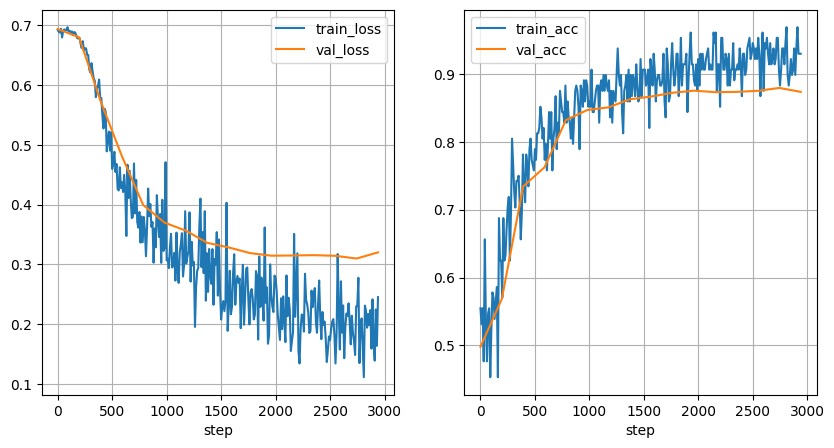

In [33]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

In [34]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/imdb-adding/best.ckpt", weights_only=True,map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3096
accuracy: 0.8793
